$$\require{mchchem}$$

In [1]:
import pip
pip.main(['install', 'numdifftools'])


0

# PFR start-up

Say we have a PFR a total volume of 20 L.  Second order kinetics, $\ce{2A->B}$, $k=1$/s, vlumetric flow rate of 2 s. 

\begin{align*}
\frac{\partial C_A}{\partial dt} = -\nu_0 \frac{\partial C_A}{\partial dV} + r_A
\end{align*}

To solve this numerically in python, we will utilize the method of lines. The idea is to discretize the reactor in volume, and approximate the spatial derivatives by finite differences. Then we will have a set of coupled ordinary differential equations that can be solved in the usual way. Let us simplify the notation with $C = C_A$, and let $r_A = -k C^2$. Graphically this looks like this:

![img](./images/pde-method-of-lines.png)

This leads to the following set of equations:

\begin{eqnarray}
\frac{dC_0}{dt} &=& 0 \text{ (entrance concentration never changes)} \\
\frac{dC_1}{dt} &=& -\nu_0 \frac{C_1 - C_0}{V_1 - V_0} - k C_1^2 \\
\frac{dC_2}{dt} &=& -\nu_0 \frac{C_2 - C_1}{V_2 - V_1} - k C_2^2 \\
\vdots \\
\frac{dC_4}{dt} &=& -\nu_0 \frac{C_4 - C_3}{V_4 - V_3} - k C_4^2 
\end{eqnarray}

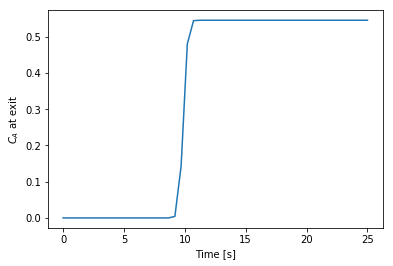

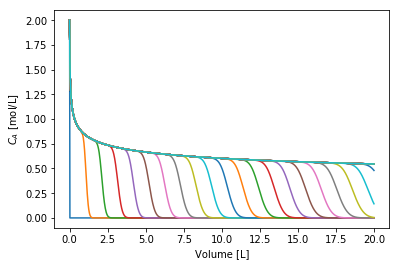

In [12]:
import numpy as np
from scipy.integrate import odeint

Ca0 = 2     # Entering concentration
vo = 2      # volumetric flow rate
volume = 20 # total volume of reactor, spacetime = 10
k = 1       # reaction rate constant

N = 1000     # number of points to discretize the reactor volume on

init = np.zeros(N)    # Concentration in reactor at t = 0
init[0] = Ca0         # concentration at entrance

V = np.linspace(0, volume, N) # discretized volume elements
tspan = np.linspace(0, 25)    # time span to integrate over

def method_of_lines(C, t, k):
    'coupled ODES at each node point'
    D = -vo * np.diff(C) / np.diff(V) - k * C[1:]**8
    return np.concatenate([[0], #C0 is constant at entrance
                            D])


sol = odeint(method_of_lines, init, tspan,(k,))

# steady state solution
def pfr(C, V):
    return 1.0 / vo * (-k * C**2)

ssol = odeint(pfr, Ca0, V)

import matplotlib.pyplot as plt
plt.plot(tspan, sol[:, -1])
plt.xlabel('Time [s]')
plt.ylabel('$C_A$ at exit')
plt.show()

for i in range(len(tspan)):
    plt.plot(V,sol[i,:])

plt.xlabel('Volume [L]')
plt.ylabel('$C_A$ [mol/L]')
plt.show()

# Sensitivity analysis

Transient PFR's can have interesting transient sensitivities since there are multiple length scales.  We want to evaluate \begin{align*}
\frac{dy_i}{dp_j}=\left.\frac{dC_A}{dk}\right|_t=\left.\frac{dC_A}{dk}\right|_t \frac{k}{C_A}
\end{align*}

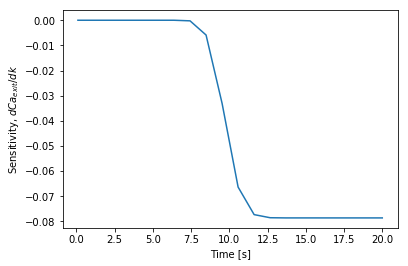

In [3]:
def conc(trange,k):
    sol = odeint(method_of_lines, init, trange,(k,))
    return sol[:,-1]

delta=0.01
trange=np.linspace(0.1,20,20)
dCadk=(conc(trange,k)-conc(trange,k*(1-delta)))/(delta*k)
plt.plot(trange,dCadk)
plt.xlabel('Time [s]')
plt.ylabel('Sensitivity, $dCa_{exit}/dk$')
plt.show()




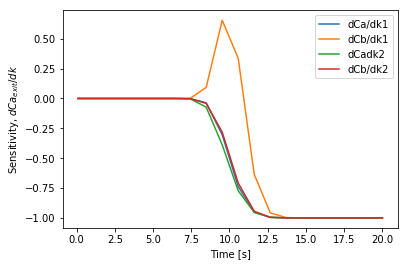

In [9]:
init = np.zeros((N,2))    # Concentration in reactor at t = 0
init[0] = Ca0         # concentration at entrance
init=init.reshape((2*N))
vo=2
def method_of_lines(C, t, k1,k2):
    'coupled ODES at each node point'
    C=C.reshape((N,2))
    D=C*0
    D[1:,0] = -vo * np.diff(C[:,0]) / np.diff(V) - k1 * C[1:,0]**2 + k1/5 * C[1:,1]
    D[1:,1] = -vo * np.diff(C[:,1]) / np.diff(V) -(- k1 * C[1:,0]**2 + k1/5 * C[1:,1]) - k2*C[1:,1]
    return D.reshape((N*2))

k1=1
k2=0.5
def exit_conc(trange,k1,k2):
    sol = odeint(method_of_lines, init, trange,(k1,k2))
    return sol.reshape((len(trange),N,2))[:,-1,:]


trange=np.linspace(0.1,20,20)

delta=0.01
k1=0.10
k2=0.5
sensitivity=[]
Sk1=(exit_conc(trange,k1*(1+delta),k2)-exit_conc(trange,k1,k2))/k1*.01
Sk2=(exit_conc(trange,k1,k2*(1+delta))-exit_conc(trange,k1,k2))/k2*.01


plt.plot(trange,Sk1[:,0]/np.max(np.abs(Sk1[:,0])),trange,Sk1[:,1]/np.max(np.abs(Sk1[:,1])),trange,Sk2[:,0]/np.max(np.abs(Sk2[:,0])),trange,Sk2[:,1]/np.max(np.abs(Sk2[:,1])))
plt.legend(['dCa/dk1','dCb/dk1','dCadk2','dCb/dk2'])
plt.xlabel('Time [s]')
plt.ylabel('Sensitivity, $dCa_{exit}/dk$')
plt.show()


# A more complicated example

Consider the PFR example from Wednesday

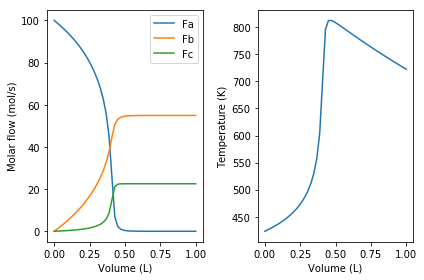

In [5]:
import numpy as np
from scipy.integrate import odeint

Fa0 = 100.0             # mol / s
Tfeed = 150.0 + 273.15  # feed temperature
Cafeed = 0.1            # mol / L

Ft0 = Fa0

v0 = Fa0 / Cafeed

# reaction properties
Hrx1 = -20.0  # kJ / mol A
Hrx2 = -60.0  # kJ / mol A

Cpa = 0.090
Cpb = 0.090
Cpc = 0.180

Ua = 4      # kJ / L / s /K
Ta = 373.0  # K

E1R = 4000.0  # K at 300 K
E2R = 9000.0


def pfr(Y, V):
    Fa, Fb, Fc, T = Y
    Ft = Fa + Fb + Fc

    k1a = 10.0 * np.exp(-E1R * (1.0 / T - 1.0 / 300.0))
    k2a = 0.09 * np.exp(-E2R * (1.0 / T - 1.0 / 300.0))

    v = v0 * (Ft / Ft0) * (T / Tfeed)
    Ca = Fa / v

    r1a = -k1a * Ca
    r2a = -k2a * Ca**2

    r1 = -r1a
    r2 = r2a / -2.0

    ra = -r1 - 2 * r2
    rb = r1
    rc = r2

    dFadV = ra
    dFbdV = rb
    dFcdV = rc

    dTdV = ((r1 * -Hrx1   # heat from rxn 1
             + 2 * r2 * -Hrx2  # heat from rxn 2
             + Ua * (Ta - T))  # Qdot
             / (Fa * Cpa + Fb * Cpb + Fc * Cpc))
    return [dFadV, dFbdV, dFcdV, dTdV]

Y0 = [Fa0, 0.0, 0.0, Tfeed]
Vspan = np.linspace(0, 1)
sol = odeint(pfr, Y0, Vspan)

Fa = sol[:, 0]
Fb = sol[:, 1]
Fc = sol[:, 2]
T = sol[:, 3]

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(Vspan, Fa, Vspan, Fb, Vspan, Fc)
plt.xlabel('Volume (L)')
plt.ylabel('Molar flow (mol/s)')
plt.legend(['Fa', 'Fb', 'Fc'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(Vspan, T)
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')
plt.tight_layout()
plt.savefig('images/pfr-mult-reactions-ua.png')
plt.show()

In [10]:
import numpy as np
from scipy.integrate import odeint
p0=[100,150+273.15,0.1,-20,-60,0.09,0.09,0.18,4,373,4000,9000]

def model(parameters):
    
    Fa0,Tfeed,Cafeed,Hrx1,Hrx2,Cpa,Cpb,Cpc,Ua,Ta,E1R,E2R=parameters

    Ft0 = Fa0

    v0 = Fa0 / Cafeed


    def pfr(Y, V):
        Fa, Fb, Fc, T = Y
        Ft = Fa + Fb + Fc

        k1a = 10.0 * np.exp(-E1R * (1.0 / T - 1.0 / 300.0))
        k2a = 0.09 * np.exp(-E2R * (1.0 / T - 1.0 / 300.0))

        v = v0 * (Ft / Ft0) * (T / Tfeed)
        Ca = Fa / v

        r1a = -k1a * Ca
        r2a = -k2a * Ca**2

        r1 = -r1a
        r2 = r2a / -2.0

        ra = -r1 - 2 * r2
        rb = r1
        rc = r2

        dFadV = ra
        dFbdV = rb
        dFcdV = rc

        dTdV = ((r1 * -Hrx1   # heat from rxn 1
                 + 2 * r2 * -Hrx2  # heat from rxn 2
                 + Ua * (Ta - T))  # Qdot
                 / (Fa * Cpa + Fb * Cpb + Fc * Cpc))
        return [dFadV, dFbdV, dFcdV, dTdV]

    Y0 = [Fa0, 0.0, 0.0, Tfeed]
    Vspan = np.linspace(0, 1)
    sol = odeint(pfr, Y0, Vspan)

    Fa = sol[:, 0]
    Fb = sol[:, 1]
    Fc = sol[:, 2]
    T = sol[:, 3]
    return np.max(T)

import numdifftools as nd
df=nd.Gradient(model)
df(p0)*p0/model(p0)


/opt/conda/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


array([ 0.04775635,  2.04482381,  0.35175587,  0.32498207,  0.59336059,
       -0.53213863, -0.2507938 , -0.12699695, -0.07360767,  0.24832323,
       -1.19923097,  3.07000116])

Most sensitive parameters: Tfeed, E2R


![img](./images/tap_principles.jpg)


# Modern topics in reaction engineering

- Homogeneous Catalysis
    - More specific catalysts
    - New reactions
    - More chemistry focused
    - Individual reaction steps that can go to completion
    - biocatalysis (enzymes, protein engineering)
- Reactor design
    - Less active research for standard configurations
    - Reactors that combine reactions and separations (process intensification)
    - Continuous processes, especially for pharmaceuticals
    - Reactors that are designed to yield kinetic information
    - Functionalization of materials/surfaces to improve lifetime
- Combustion chemistry
    - high temperature, many products
    - thousands (or more) reactions
    - reaction mechanism reduction
    - turbulence
- Heterogeneous catalysis
    - Materials stability
    - Catalyst materials (cost, performance)
    - Catalyst structure, support
    - Electrochemical catalysis
    - Multifunctional materials (multiple catalysts nearby)
    - Porous materials like zeolites
- New processes
    - Green chemistry (non-petroleum feedstocks)
    - Direct chemistries: replace multiple reactors with one single reactor (A->C instead of A->B->C)
    - Enantiospecific chemistry, mainly for pharmaceuticals
    - Reactions in harsh environments (plasma, ionic liquids)
- High-throughput methods
    - For all of the above, use multiple reactors in parallel to quickly run experiments to test materials or determine parameters
- Systems engineering approaches
    - Optimal experiments to determine kinetics
    - Design under uncertainty
    - Model discrimination
- Modeling
    - Expectation that reactions can be understood at the molecular level
    - Method development such as DFT, etc
    - Multiscale modeling; combination of molecular, mesoscale, microscale, macroscale, unit scale models 

# Exam 3 topics 

Exam is cumulative, everything is fair game. Things that were covered after exam 2

- Generalized effectiveness factors (more complicated kinetics)
- Non-isothermal reactor design
    - Energy balance equations
    - Batch, CSTR, transient CSTR, PFR
    - Multiple steady states, SS transients
    - Multiple reactions, thermodynamics